In [70]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import math
import hcp_utils as hcp

import conf
import helper_functions
import roi_analysis_func
import importlib
import model_preparation_functions

In [71]:
#path to ROIs_corr
#path_ROI_corr = conf.RESULTS_DIR + 'res_vmPFC_vis.csv'
path_ROI_corr = conf.RESULTS_DIR + 'res_vis_value.csv'

#path to subject IDs 
path_sub = conf.BASE_DIR + conf.X_FEATURES_DIR + conf.SUB_ID_FILENAME

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = conf.BASE_DIR + 'Behavior/HCP_behavior_includeZscores.csv'

df_ROI_corr = pd.read_csv(path_ROI_corr)
subject_IDs = np.loadtxt(path_sub)
subject_IDs = subject_IDs.astype(int) #turn the subject IDS into integers
df_behav = pd.read_csv(path_behavior)

In [72]:
df_ROI_corr = df_ROI_corr.rename(columns={'Unnamed: 0':'Subject'})

In [73]:
df_behav = df_behav[df_behav['Subject'].isin(subject_IDs)]
df_behav.shape

(990, 590)

In [74]:
subjectBehavior = df_behav['Subject']
subjectDifference = np.setdiff1d(subject_IDs, subjectBehavior)
subjectDifference

array([314225, 392750])

In [76]:
df_ROI_corr= df_ROI_corr[(df_ROI_corr.Subject != subjectDifference[0]) & (df_ROI_corr.Subject != subjectDifference[1]) ]

In [77]:
df_ROI_corr =  df_ROI_corr.sort_values(by=['Subject'], ascending=True,  ignore_index=True)
df_ROI_corr

,Subject,R,p
0,100206,0.110085,2.038357e-14
1,100307,-0.006637,6.457076e-01
2,100408,0.345968,4.986443e-135
3,100610,0.161281,2.461090e-29
4,101006,0.073520,3.411601e-07
...,...,...,...
985,992673,0.179742,3.875695e-36
986,992774,0.155206,2.897169e-27
987,993675,0.220498,6.140724e-54
988,994273,0.411471,1.521625e-195


In [78]:
#Set subject ID as index
df_ROI_corr = df_ROI_corr.set_index('Subject')
df_ROI_corr

,R,p
Subject,,
100206,0.110085,2.038357e-14
100307,-0.006637,6.457076e-01
100408,0.345968,4.986443e-135
100610,0.161281,2.461090e-29
101006,0.073520,3.411601e-07
...,...,...
992673,0.179742,3.875695e-36
992774,0.155206,2.897169e-27
993675,0.220498,6.140724e-54


In [79]:
df_ROI_corr["R_abs"] = abs(df_ROI_corr["R"])

In [80]:
df_ROI_corr

,R,p,R_abs
Subject,,,
100206,0.110085,2.038357e-14,0.110085
100307,-0.006637,6.457076e-01,0.006637
100408,0.345968,4.986443e-135,0.345968
100610,0.161281,2.461090e-29,0.161281
101006,0.073520,3.411601e-07,0.073520
...,...,...,...
992673,0.179742,3.875695e-36,0.179742
992774,0.155206,2.897169e-27,0.155206
993675,0.220498,6.140724e-54,0.220498


In [81]:
#Set subject ID as index
df_behav = df_behav.set_index('Subject')
df_behav

,Unnamed: 0,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType,z_score_compare,GroupType_f,z_score_compare_f
Subject,,,,,,,,,,,,,,,,,,,,,
100206,1,S900,Q11,M,26-30,True,1,1,4,100.0,...,1.84,0.0,1.84,0.032707,-1.579802,1.496190,3,1.612509,3,3.075992
100307,2,Q1,Q01,F,26-30,True,1,1,4,100.0,...,1.76,0.0,1.76,-0.114713,-0.668222,0.050336,0,0.553509,3,0.718558
100408,3,Q3,Q03,M,31-35,True,1,1,4,100.0,...,1.76,2.0,1.68,-0.262134,-0.285068,1.196163,0,0.022934,3,1.481231
100610,4,S900,Q08,M,26-30,True,2,1,4,100.0,...,1.92,1.0,1.88,0.106417,1.274788,1.262287,2,1.168371,2,0.012500
101006,5,S500,Q06,F,31-35,True,2,2,4,100.0,...,1.80,0.0,1.80,-0.041003,0.976073,-0.894157,1,1.017076,1,1.870230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992673,1200,S900,Q12,F,31-35,True,1,2,4,100.0,...,1.80,0.0,1.80,-0.041003,1.006035,-1.703441,1,1.047038,1,2.709476
992774,1201,Q2,Q02,M,31-35,True,2,2,4,100.0,...,1.76,0.0,1.76,-0.114713,-1.686032,1.422170,0,1.571319,3,3.108202
993675,1202,S900,Q09,F,26-30,True,2,2,4,100.0,...,1.80,1.0,1.76,-0.114713,1.517210,0.500377,1,1.631924,2,1.016834


In [82]:
#Make sure the subject lists in the fMRI data and behavior data are equal
assert df_behav.index.equals(df_ROI_corr.index), "Row (subject) indices of FC vcts and behavior don't match!"

<AxesSubplot:xlabel='R'>

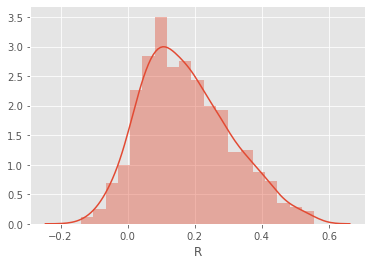

In [83]:
sns.distplot(df_ROI_corr['R'])

<AxesSubplot:xlabel='z_score_mars'>

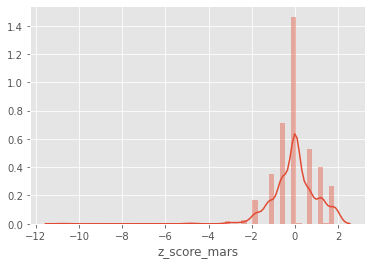

In [62]:
var = df_behav['z_score_mars']
var_scaled = (var - np.mean(var,axis=0))/np.std(var,axis=0)
sns.distplot(var_scaled)

<AxesSubplot:xlabel='R', ylabel='z_score_compare_f'>

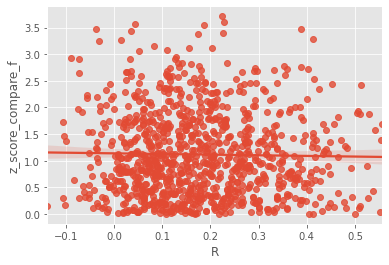

In [92]:
#Correlation between Flanker task and Delay Discount task
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

x = df_ROI_corr['R']
y = df_behav['z_score_compare_f']

#sc.stats.pearsonr(x, y)

#plt.scatter(x, y)
#plt.show()

sns.regplot(x, y)

In [91]:
pearsonr(x, y)

(-0.012671426212083652, 0.6904758327357763)

In [93]:
#the permutation test as "how many times obtain a correlation coefficient that is greater than the observed value?"
from mlxtend.evaluate import permutation_test
#link: http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/

print('Observed pearson R: %.2f' % np.corrcoef(x, y)[1][0])


p_value = permutation_test(x, y,
                           method='approximate', num_rounds=10000,
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           seed=0)
print('P value: %.2f' % p_value)

Observed pearson R: -0.02
P value: 0.74
